In [18]:
"""
@author: Pearl Saldanha
"""
import matplotlib.pyplot as plt
import numpy as np
import nxsdk.api.n2a as nx
from nxsdk.utils.plotutils import plotRaster
import wta1d as wta1d
import os
os.environ["KAPOHOBAY"] = "1"


def create_spikegen(net, indices, spiketimes, numPorts=None):
    """
    creates a spikegenerator from a list of indices with corresponding spiketimes
    :param net: the nx net in which the spikegen is created
    :param indices: the neuron indices that correspond to the spiketimes
    :param spiketimes: times at which the spikegen spikes
    :param numPorts: the numebr of spikegen neurons, if None, it is the max of indices
    :param time_step: time in milliseconds
    :return: spikegenerator (needed to connect to other groups)
    """
    if numPorts is None:
        numPorts = np.max(indices)
        
    print('length of stimulation is', np.max(spiketimes), 'timesteps')
    spikegen = net.createSpikeGenProcess(numPorts=numPorts)
    for sg_neuron in np.unique(np.asarray(indices)):
        spikegen.addSpikes(spikeInputPortNodeIds=sg_neuron,
                           spikeTimes=list(spiketimes[np.where(indices == sg_neuron)]))
    return spikegen


In [2]:
net = nx.NxNet()

#ports
num_syn =36
num_recall = 36

spiketimes = np.asarray([5,6,8,9,10,11,12,1500,1501,1502,1503,1504,1505,1506]) 
indices =np.asarray([0]*len(spiketimes))

time_step = 1.00 #GLOBAL time step duration in milliseconds (spiking rate and time constant defined in MILLISECONDS)
simulated_time = 3000 #length of the simulation in milliseconds
sumulated_steps = int(simulated_time/time_step) #number of simulated steps
runtime = sumulated_steps

print("Length of 'indices' = ", len(indices))
print("Length of 'spiketime' = ", len(spiketimes))
print("Print-out of indices array: ", indices)

Length of 'indices' =  14
Length of 'spiketime' =  14
Print-out of indices array:  [0 0 0 0 0 0 0 0 0 0 0 0 0 0]


[[0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


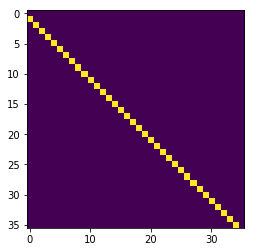

In [3]:
sf1 = nx.CompartmentPrototype(biasMant=0,
                            biasExp=0,
                            vThMant=20000,
                            functionalState=2,
                            refractoryDelay=2,
                            compartmentVoltageDecay=int(4096/20),
                            compartmentCurrentDecay=int(4096/15),
                            numDendriticAccumulators = 16,   
                            logicalCoreId=0)

synfire1 = net.createCompartmentGroup(size=num_syn, prototype=sf1)

#connection prototype
conn_proto_exc = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.EXCITATORY,
                                        weight=145,
                                        weightExponent=4,
                                        numWeightBits=6,
                                        enableDelay=1,
                                        numDelayBits =4,
                                        delay=14)

#connection mask                                     
conn_mask = np.zeros((num_syn,num_syn))
for i in range(num_syn-1):
    #conn_mask[i,i+1]= 1
    conn_mask[i+1,i] = 1
    
print(conn_mask)
plt.imshow(conn_mask)

#compartment connections
exc_exc = synfire1.connect(synfire1, prototype=conn_proto_exc,connectionMask=conn_mask)

length of stimulation is 1506 timesteps


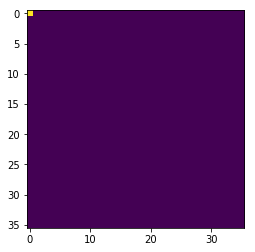

In [4]:
# =======================================================
# Creation of connections from spikeGen to synfire chain
# =======================================================

# Connection mask for the spikeGen
conn_mask_spikegen = np.zeros((num_syn, num_syn))
# conn_mask_spikegen[0,:] = 1  # Connects all spikeGen ports to only the first neuron in the synfire chain
conn_mask_spikegen[0,0] = 1  # Connects only the first port of the spikeGen to the first neuron in the synfire chain

# Draw excitatory connections from the spikeGen (using 'conn_mask_spikegen')
# sg = create_spikegen(net, indices, spiketimes, numPorts=num_src)

# spike_gen.connect(cx_grp,
#                   prototype=conn_proto,
#                   weight=np.ones((num_dst, num_src)) * int(weight_steps),
#                   delay=np.ones((num_dst, num_src)) * int(delay_steps),
#                   connectionMask=conn_mask)

# # Plot connection mask
# if plotConnMatrices or printConnMatrices:
#     print("Connection matrix for spike gen to synfire chain:")
# if plotConnMatrices:
plt.imshow(conn_mask_spikegen)
# if printConnMatrices:
#     print(conn_mask_spikegen)


# spike generator
sg = create_spikegen(net, indices, spiketimes, numPorts=num_syn)
sg.connect(synfire1,
           prototype=conn_proto_exc,
            connectionMask=conn_mask_spikegen)

s_probes = synfire1.probe([nx.ProbeParameter.SPIKE])

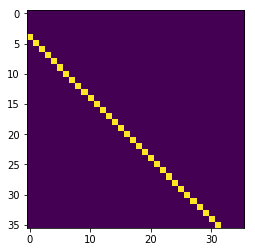

In [5]:
sr1 = nx.CompartmentPrototype(biasMant=0,
                            biasExp=0,
                            vThMant=20000,
                            functionalState=2,
                            refractoryDelay=2,
                            compartmentVoltageDecay=int(4096/20),
                            compartmentCurrentDecay=int(4096/15),
                            numDendriticAccumulators = 16,   
                            logicalCoreId=0)

synrecall1 = net.createCompartmentGroup(size=num_recall, prototype=sr1)

conn_mask_recall = np.zeros((num_syn,num_recall))
for i in range(num_syn):
    if i+4 < num_recall:
        conn_mask_recall[i+4,i] = 1
plt.imshow(conn_mask_recall)       

syn_sr = synfire1.connect(synrecall1, prototype=conn_proto_exc,connectionMask=conn_mask_recall)

sr_probes = synrecall1.probe([nx.ProbeParameter.SPIKE])

In [6]:
net.run(runtime)
net.disconnect()

INFO:DRV:  Connecting to 127.0.0.1:18861
INFO:DRV:  N2Driver: Running...
INFO:DRV:      Compiling synapses... Done (0.01s)
INFO:DRV:      Processing probes... Done (0.00s)
INFO:DRV:      Writing modified registers... Done (0.01s)
INFO:DRV:      Initializing... Done (0.01s)
INFO:DRV:      Preparing input... Done (0.01s)
INFO:DRV:      Executing... Done (14.77s)
INFO:DRV:      Processing timeSeries... Done (0.09s)
INFO:DRV:  N2Driver: Finished (14.90s)


Text(0.5, 1.0, 'Spikes from synfire chain')

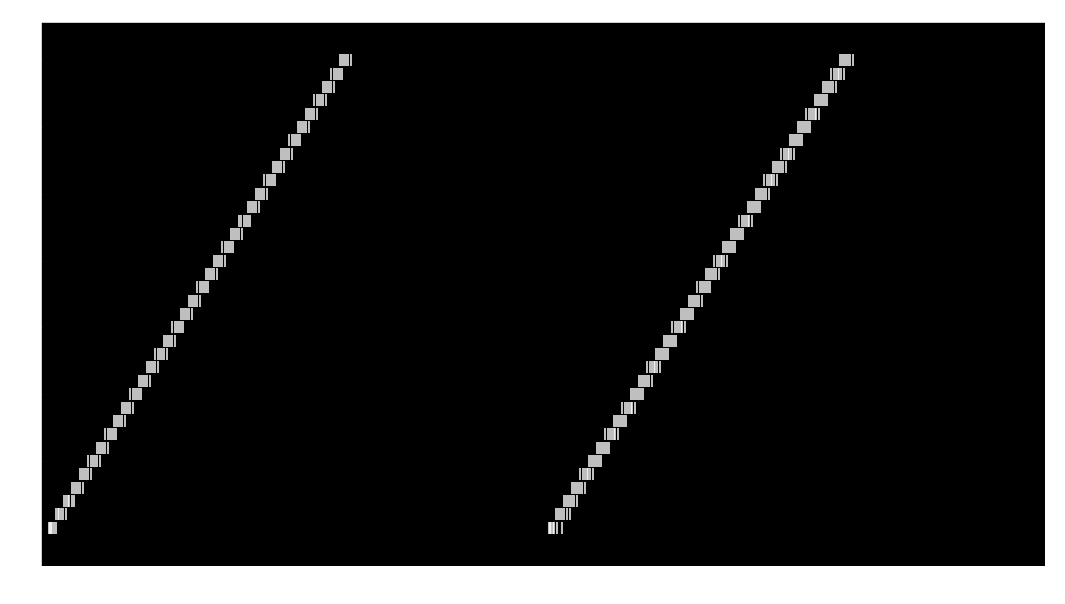

In [7]:
fig = plt.figure(1, figsize=(18,10))
plt.style.use("dark_background") # for use with dark theme editor

plot_begin = 0
plot_end = runtime
s_probes[0]
# Plot output spikes of the synfire chain

syn = s_probes[0].plot() #colors=[h.get_color() for h in uh])
plt.xlim(plot_begin,plot_end)
plt.title('Spikes from synfire chain')


Text(0.5, 1.0, 'Spikes from recall chain')

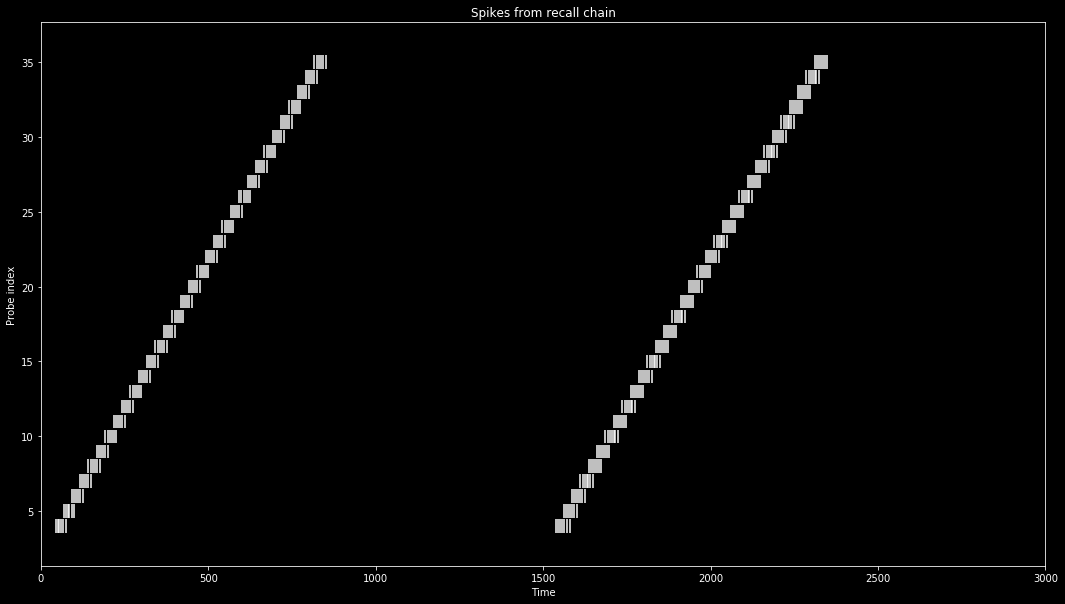

In [8]:
fig = plt.figure(1, figsize=(18,10))
plt.style.use("dark_background") # for use with dark theme editor

plot_begin = 0
plot_end = runtime
sr_probes[0]
# Plot output spikes of the synfire chain

sr1 = sr_probes[0].plot() #colors=[h.get_color() for h in uh])
plt.xlim(plot_begin,plot_end)
plt.title('Spikes from recall chain')

In [20]:
A =2.5
f = 50
t = 5

In [19]:
import numpy as np
import math 
import wta1d as wta1d
net = nx.NxNet()


time_step = 1.00

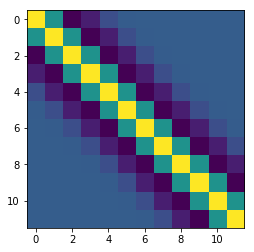

In [22]:
wta_size = 12
sigma = 1.3
weight_max = 200 #150#120
weight_min_global = -0.4*weight_max #20
#weight_min_peak = -10.0*weight_max + shift#min weight in the negative peaks of the mexican hat function (DoG implementation)
syn_delay = 1
self_excitation = True
runtime = 5000
time_step = 1.00 #GLOBAL time step dureation in milliiseconds (spiking rate and time constant defined in MILLISECONDS)

def func_to_learn(x):
    return 12+10*np.sin(x*0.25)

cx_proto = wta1d.create_compartment_prototype(time_step = time_step,
                                             tau_current_decay = 10,
                                             tau_voltage_decay = 150,#150,
                                             threshold_voltage_mant = 4000,# 3000, #*2^6
                                             min_voltage_exp = 16,#17,#-2^min_voltage_exp
                                             enable_backprop = True, #learning between wtas
                                             logicalCoreId=1)

#create wta
wta = wta1d.WtaNet(net,wta_size,'mexican',sigma,0,weight_min_global,
                     weight_max,self_excitation,syn_delay,time_step,cx_proto)

wta.create()
# wta.print_parameters()
# print(wta.w_matrix)
plt.imshow(wta.w_matrix)

In [ ]:
spikegen = wta.create_spike_gen()

In [15]:
wta.add_gaussian_input(A*np.sin(2*np.pi*f*t))

NameError: name 'wta' is not defined